# Preparing a computer vision training set for labeling photos 



This notebook covers the steps involved in preparing a labeled dataset of images derived from the Newspaper Navigator dataset. Specifically this training set is primarily intended for use in a Programming Historian lesson on computer vision. 

## Aims 
This notebook cover the steps to creating a dataset based on the news-navigator dataset. This includes:
- creating a subsample of the news navigator training set
- setting up the annotation process
- processing the annotations 
- uploading the dataset to Zenodo

It doesn't cover training a model based on this data. This process is covered in a the programming historian lesson for which this dataset was created. 


## Creating a sample

We start by importing the `sample` module. 

In [7]:
from nnanno.sample import *

We create an nnSampler instance which we can use to create a sample. 

In [8]:
sampler = nnSampler()

We can access some information about the 'population' from the sampler object. For example we can see how the number of photos in the collection changes over time.

<AxesSubplot:>

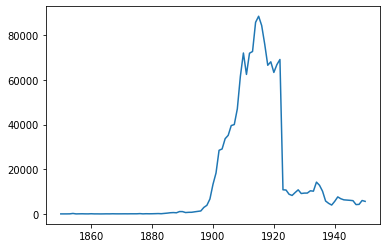

In [14]:
sampler.population['photos_count'].plot()

We should be careful when looking at a chart like this of not mistaking this as a full representation. In this case we need to know some context about collections like the Chronicling America corpus from which the Newspaper Navigator data was draw since these collections are neither 'neutral' nor entirely representative. For example the sharp drop ~1920 in the number of photographs for each year could be mistaken as a sudden drop in the number of newspapers publishing photos. Evan a cursory knowledge of photojournalism would challenge this assumption, with the 1930s-1950s considered a [golden age](https://en.wikipedia.org/wiki/Photojournalism#Golden_age) of photojournalism. The drop is in this case more easily explained by the context in which this collection was made and specifically in this case the influence of copyright on digitization policies. 

To create a sample we define a few variables for a sample. `sample_size` is the size we want for our sample. If `year_sample` is true then this will be the sample size for each year. In this case since we want to create a sample size we want to annotate we set `year_sample` to `False`. `kind` refers to the predicted label from Newspaper Navigator. Because photography in newspapers appeared later in the 19th Century, we choose a later `start_year` and stop at 1920 when the number of images in the data drops off massively. `step` can be used to change the step between sample years. In this case we sample every year but we could change this to ever `n` years. 

In [ ]:
df_photos_sample = sampler.create_sample(sample_size=2000, 
                                         kind='photos',
                                         start_year=1895, 
                                         end_year=1920, 
                                         step=1, 
                                         year_sample=False)

We get back pandas DataFrame containing the newspaper navigator dataset. This includes metadata about the newspaper form which the image came from, the `box` which contains the predicted bounding box coordinates for the predicted visual content from newspaper navigator. 

In [7]:
df_photos_sample.head(1)

,filepath,pub_date,page_seq_num,edition_seq_num,batch,lccn,box,score,ocr,place_of_publication,geographic_coverage,name,publisher,url,page_url
0,mthi_kestrel_ver02/data/sn85053323/print/18951...,1895-11-28,696,1,mthi_kestrel_ver02,sn85053323,"[0.6757705539920897, 0.13269955294949193, 0.88...",0.989924,"[AVM., SCHEMA, V,]","Neihart, Mont.",[Montana--Cascade--Neihart],The Neihart herald. [volume],Herald Pub. Co.,https://news-navigator.labs.loc.gov/data/mthi_...,https://chroniclingamerica.loc.gov/data/batche...


Now we have our sample we want to annotate this sample with labels which we'll then use to train a computer vision model on. In this case we will annotate by creating `IIIF` urls which we then load into the [label studio](https://labelstud.io) annotation tool. 

In [9]:
from nnanno.annotate import *

We'll create a folder to store our annotations 

In [10]:
from pathlib import Path

In [8]:
Path('ph/photos_multi').mkdir()

We'll use a small function to convert our sample DataFrame into a JSON file which we'll use to load our 'tasks' i.e. images into label studio and save this into our folder. The `size` variable is used to determine the size we request via IIIF. In this case we use a relatively small size to annotate since this will make the loading of the images a bit quicker. 

In [12]:
create_label_studio_json(sampler, 'ph/photos_multi/photo_tasks.json', size=(500,500))

Now we have our sample in a format that label studio can take as input we'll setup the annotations. There are various ways we can do this, one way is via the GUI app. To setup a new label-studio annotation environment we'll use the `init` command and give a name for our project. 

`label-studio init photo-annotations`

This will launch label-studio. From here we can load our tasks by uploading our photo_tasks.json file. 

We then create our labels. The label studio documentation goes into detail on how to setup labels. For simple tasks it's often easiest to use one of the templates and then adjust the labels as required. For this example dataset the following is used:

```xml
<View>
  <Choices name="choice" toName="image" showInLine="true" choice="multiple">
        <Choice value="human"/>
    	<Choice value="animal"/>
    	<Choice value="human-structure"/>
     	<Choice value="landscape"/>
  </Choices>
<Image name="image" value="$image"/>
</View>
```

Once we have completed the annotations we can export them to a CSV file using the export functionality within label studio. This will contain our original sample plus our new data. 

In [29]:
df = load_annotations_csv('ph/photos_multi/results.csv', kind='label')

Since we'll want the images locally for training models we'll now download the images associated with our labels. We can do this using the `download_sample` method from `nnsampler` and passing our DataFrame. 

In [31]:
sampler.download_sample('ph/photos_multi/images', df=df)

This download method will try and download all of the images associated with the annotations DataFrame but there may be some that are not available. We can quickly compare the downloaded image folder and DataFrame

In [32]:
check_download_df_match('ph/photos_multi/images', df)

Length of DataFrame 2000 and number of images in ph/photos_multi/images 2000 match 😀


We'll save the annotations to a new CSV file that contains the processed 'labels' column we'll use when training our model. 

In [33]:
df.to_csv('ph/photos_multi/annotations.csv')

We'll also create a version with just the labels and images

In [39]:
df = pd.read_json('ph/photos_multi/images/2021_01_02_16_38_2000_sample.json')[['download_image_path','label']]

In [40]:
df.to_csv('ph/photos_multi/multi_label.csv', index=False)

### Upload to Zenodo

*This section is obviously optional. This is shown here only since this was the process used for this data. Most of these instructions are taken directly from the Zenodo docs.*

First we zip our image directory 

In [41]:
!zip -j -r -q ph/photos_multi/images.zip ph/photos_multi/images

We import a few more libraries

In [42]:
from dotenv import load_dotenv
import os
import requests 
from pathlib import Path
from tqdm.notebook import tqdm

`dotenv` is used to load the credenitals for the zenodo api. These credentials shouldn't be shared so we don't want them included in a notebook being shared publicly. There are different ways of managing these kinds of credentials with one simple way is to put them in a `.env` file. This can be access by dotenv but won't be versioned by Git so avoids sharing our credentials with the wider world. 

In [43]:
load_dotenv()

True

In [44]:
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")

The Zenodo repository allows for uploads via an API. In the below cells I have just followed the steps outlined in the zenodo [documentation](https://developers.zenodo.org/).

In [45]:
r = requests.get('https://zenodo.org/api/deposit/depositions',params={'access_token': ACCESS_TOKEN})

In [46]:
r.status_code

200

In [47]:
headers = {"Content-Type": "application/json"}
params={'access_token': ACCESS_TOKEN}
r = requests.post('https://zenodo.org/api/deposit/depositions',
                   params=params,
                   json={},
                   headers=headers)
r.status_code

201

In [48]:
r.json()

{'conceptrecid': '4487140',
 'created': '2021-02-01T17:03:26.087698+00:00',
 'files': [],
 'id': 4487141,
 'links': {'bucket': 'https://zenodo.org/api/files/d35b386f-98eb-404a-ba1e-c119f9f23b40',
  'discard': 'https://zenodo.org/api/deposit/depositions/4487141/actions/discard',
  'edit': 'https://zenodo.org/api/deposit/depositions/4487141/actions/edit',
  'files': 'https://zenodo.org/api/deposit/depositions/4487141/files',
  'html': 'https://zenodo.org/deposit/4487141',
  'latest_draft': 'https://zenodo.org/api/deposit/depositions/4487141',
  'latest_draft_html': 'https://zenodo.org/deposit/4487141',
  'publish': 'https://zenodo.org/api/deposit/depositions/4487141/actions/publish',
  'self': 'https://zenodo.org/api/deposit/depositions/4487141'},
 'metadata': {'prereserve_doi': {'doi': '10.5281/zenodo.4487141',
   'recid': 4487141}},
 'modified': '2021-02-01T17:03:26.087708+00:00',
 'owner': 32477,
 'record_id': 4487141,
 'state': 'unsubmitted',
 'submitted': False,
 'title': ''}

In [49]:
bucket_url = r.json()["links"]["bucket"]

In [50]:
files = [f for f in Path('ph/photos_multi').iterdir() if f.is_file() and not f.name.startswith('.')]
files

[PosixPath('ph/photos_multi/images.zip'),
 PosixPath('ph/photos_multi/multi_label.csv'),
 PosixPath('ph/photos_multi/annotations.csv'),
 PosixPath('ph/photos_multi/results.csv'),
 PosixPath('ph/photos_multi/photo_tasks.json')]

In [51]:
for file in tqdm(files):
    with open(file,"rb") as fp:
        r = requests.put(
            "%s/%s" % (bucket_url, file),
            data=fp,
            params=params)
r.json()

{'mimetype': 'application/json',
 'updated': '2021-02-01T17:12:24.999647+00:00',
 'links': {'self': 'https://zenodo.org/api/files/d35b386f-98eb-404a-ba1e-c119f9f23b40/ph/photos_multi/photo_tasks.json',
  'version': 'https://zenodo.org/api/files/d35b386f-98eb-404a-ba1e-c119f9f23b40/ph/photos_multi/photo_tasks.json?versionId=e4eb4982-50f4-490f-99b1-d1060de83805',
  'uploads': 'https://zenodo.org/api/files/d35b386f-98eb-404a-ba1e-c119f9f23b40/ph/photos_multi/photo_tasks.json?uploads'},
 'is_head': True,
 'created': '2021-02-01T17:12:24.994665+00:00',
 'checksum': 'md5:d79ed84baafb5c8f089ba37614be9335',
 'version_id': 'e4eb4982-50f4-490f-99b1-d1060de83805',
 'delete_marker': False,
 'key': 'ph/photos_multi/photo_tasks.json',
 'size': 2646679}

### Metadata

Once this has been done we should make sure we create an additional metadata related to the upload within Zenodo. 

### Datasheets for Datasets

Beyond making sure that we complete the 'standard' metadata field, when creating a dataset intended for training a deep learning model you may want to consider giving a broader context to the data, how it was gathered and some of the potential limitations of with the data. These limitations may become apparent to you but may be less obvious to new users of the data particularly since these users may be divorced from the immediate context under which this data was gathered. 

One approach to documenting this kind of information is outlined in [Datasheets for Datasets](https://arxiv.org/abs/1803.09010) by Gebru *et al*. The paper abstract gives some background to the motivations and suggested solutions:

> The machine learning community currently has no standardized process for documenting datasets, which can lead to severe consequences in high-stakes domains. To address this gap, we propose datasheets for datasets. In the electronics industry, every component, no matter how simple or complex, is accompanied with a datasheet that describes its operating characteristics, test results, recommended uses, and other information. By analogy, we propose that every dataset be accompanied with a datasheet that documents its motivation, composition, collection process, recommended uses, and so on. Datasheets for datasets will facilitate better communication between dataset creators and dataset consumers, and encourage the machine learning community to prioritize transparency and accountability. 

You can see the record for this data on Zenodo ([10.5281/zenodo.4487141]()) which attempts to put (some) of this paper into practice. 

### fin